<a href="https://colab.research.google.com/github/ymubarka/finetuning_methods/blob/main/Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Fonts, imports, and functions

In [1]:
# Making plot text better
!wget https://fonts.google.com/download?family=Lato
!unzip 'download?family=Lato'
!mkdir /usr/share/fonts/truetype/Lato
!mv Lato-* /usr/share/fonts/truetype/Lato/
!rm download?family=Lato
!rm OFL.txt

!wget https://fonts.google.com/download?family=Roboto
!unzip 'download?family=Roboto'
!mkdir /usr/share/fonts/truetype/Roboto
!mv Roboto-* /usr/share/fonts/truetype/Roboto/
!rm download?family=Roboto
!rm LICENSE.txt

!pip install umap-learn
!pip install torch_cka

--2023-01-18 02:22:13--  https://fonts.google.com/download?family=Lato
Resolving fonts.google.com (fonts.google.com)... 142.250.101.139, 142.250.101.138, 142.250.101.102, ...
Connecting to fonts.google.com (fonts.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download?family=Lato’

download?family=Lat     [ <=>                ] 345.27K  --.-KB/s    in 0.1s    

2023-01-18 02:22:14 (2.91 MB/s) - ‘download?family=Lato’ saved [353557]

Archive:  download?family=Lato
  inflating: OFL.txt                 
  inflating: Lato-Thin.ttf           
  inflating: Lato-ThinItalic.ttf     
  inflating: Lato-Light.ttf          
  inflating: Lato-LightItalic.ttf    
  inflating: Lato-Regular.ttf        
  inflating: Lato-Italic.ttf         
  inflating: Lato-Bold.ttf           
  inflating: Lato-BoldItalic.ttf     
  inflating: Lato-Black.ttf          
  inflating: Lato-BlackItalic.ttf    
--2023-01-18 02:2

In [2]:
import matplotlib.font_manager as fm

font_dir = ['/usr/share/fonts/truetype/Lato','/usr/share/fonts/truetype/Roboto']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib
import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
import os
import pathlib

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
import torchvision.models as models
from tqdm.notebook import tqdm
import pandas as pd
import pickle

import umap
from torch_cka import CKA


matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["font.family"] = "Roboto"

def load_new_test_data(root, version_string=''):
    data_path = root
    filename = 'cifar10.1'
    if version_string == '':
        version_string = 'v7'
    if version_string in ['v4', 'v6', 'v7']:
        filename += '_' + version_string
    else:
        raise ValueError('Unknown dataset version "{}".'.format(version_string))
    label_filename = filename + '_labels.npy'
    imagedata_filename = filename + '_data.npy'
    label_filepath = os.path.abspath(os.path.join(data_path, label_filename))
    imagedata_filepath = os.path.abspath(os.path.join(data_path, imagedata_filename))
    print('Loading labels from file {}'.format(label_filepath))
    assert pathlib.Path(label_filepath).is_file()
    labels = np.load(label_filepath)
    print('Loading image data from file {}'.format(imagedata_filepath))
    assert pathlib.Path(imagedata_filepath).is_file()
    imagedata = np.load(imagedata_filepath)
    assert len(labels.shape) == 1
    assert len(imagedata.shape) == 4
    assert labels.shape[0] == imagedata.shape[0]
    assert imagedata.shape[1] == 32
    assert imagedata.shape[2] == 32
    assert imagedata.shape[3] == 3
    if version_string == 'v6' or version_string == 'v7':
        assert labels.shape[0] == 2000
    elif version_string == 'v4':
        assert labels.shape[0] == 2021
    return imagedata, labels


class CIFAR10p1(Dataset):

    def __init__(self, root, split='test', version='v6', transform=None):
        super().__init__()
        imagedata, labels = load_new_test_data(root=root, version_string=version)
        self._transform = transform
        self._imagedata = imagedata
        self._labels = torch.LongTensor(labels)
        
    def __getitem__(self, i):
        x = Image.fromarray(np.uint8(self._imagedata[i]))
        if self._transform is not None:
            x = self._transform(x)
        y = self._labels[i]
        return x, y

    def __len__(self) -> int:
        return len(self._imagedata)


class STL10_CIFAR(Dataset):
    """
    Converts STL10 labels to match CIFAR10 labels. Also removes "monkey" class
    since it isn't in CIFAR10.
    """
    def __init__(self, dataset):
        super().__init__()
        stl_to_cifar_indices = np.array([0, 2, 1, 3, 4, 5, 7, -1, 8, 9])
        self.dataset = dataset
        self.labels = stl_to_cifar_indices[self.dataset.labels]
        self.dataset.labels = stl_to_cifar_indices[self.dataset.labels]
        self.dataset = torch.utils.data.Subset(
            self.dataset, np.where(self.dataset.labels != -1)[0]
        )
        self.labels = self.labels[np.where(self.labels != -1)[0]]
        
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        label = self.labels[idx]
        return (image, label)

    def __len__(self):
        return len(self.labels)


def load_moco(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model = models.__dict__[checkpoint['arch']]()

    state_dict = checkpoint['state_dict']
    for k in list(state_dict.keys()):
        # retain only encoder_q up to before the embedding layer
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            state_dict[k[len("module.encoder_q."):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]
    msg = model.load_state_dict(state_dict, strict=False)
    assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
    return model

# 1. Visualizing CIFAR 10 and related datasets

## 1.1 CIFAR10, CIFAR10.1, STL10

In [4]:
# Setting up 
batch_size = 64

normalize = transforms.Compose([transforms.ToTensor()])

cifar10_train = CIFAR10(root='drive/MyDrive/finetuning_project/data/', train=True, transform=normalize, download=True)
cifar10_test = CIFAR10(root='drive/MyDrive/finetuning_project/data/', train=False, transform=normalize, download=True)

# CIFAR 10.1 requires manual installation
# https://github.com/modestyachts/CIFAR-10.1
train_dataset_cifar10p1 = CIFAR10p1(
            root="drive/MyDrive/finetuning_project/data/cifar10p1",
            split="test",
            version="v6",
            transform=normalize,
        )

test_dataset_stl10 = torchvision.datasets.STL10(
    root="drive/MyDrive/finetuning_project/data",
    split="test",
    download=True,
    transform=normalize)
test_dataset_stl10 = STL10_CIFAR(test_dataset_stl10)


train_loader = torch.utils.data.DataLoader(
    cifar10_train,
    batch_size=batch_size,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=batch_size,
    shuffle=False)
test_loader_cifar10p1 = torch.utils.data.DataLoader(
    train_dataset_cifar10p1,
    batch_size=batch_size,
    shuffle=False)
test_loader_stl10 = torch.utils.data.DataLoader(
    test_dataset_stl10,
    batch_size=batch_size,
    shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Loading labels from file /content/drive/MyDrive/finetuning_project/data/cifar10p1/cifar10.1_v6_labels.npy
Loading image data from file /content/drive/MyDrive/finetuning_project/data/cifar10p1/cifar10.1_v6_data.npy
Files already downloaded and verified


In [5]:
# Getting a sample from each class from each dataset
orig_img_dict = {}
orig_img_dict["cifar10_train"] = [cifar10_train.targets.index(i) for i in range(10)]
orig_img_dict["cifar10_test"] = [cifar10_test.targets.index(i) for i in range(10)]
orig_img_dict["cifar10.1"] = [train_dataset_cifar10p1._labels.tolist().index(i) for i in range(10)]
orig_img_dict["stl10"] = [test_dataset_stl10.labels.tolist().index(i) for i in range(10) if i != 6]

title_dict = {
    "cifar10_train": "CIFAR 10 \nTrain",
    "cifar10_test": "CIFAR 10 \nTest",
    "cifar10.1": "CIFAR 10.1",
    "stl10": "STL 10",
}

datasets_dict = {}
datasets_dict["cifar10_train"] = cifar10_train
datasets_dict["cifar10_test"] = cifar10_test
datasets_dict["cifar10.1"] = train_dataset_cifar10p1
datasets_dict["stl10"] = test_dataset_stl10

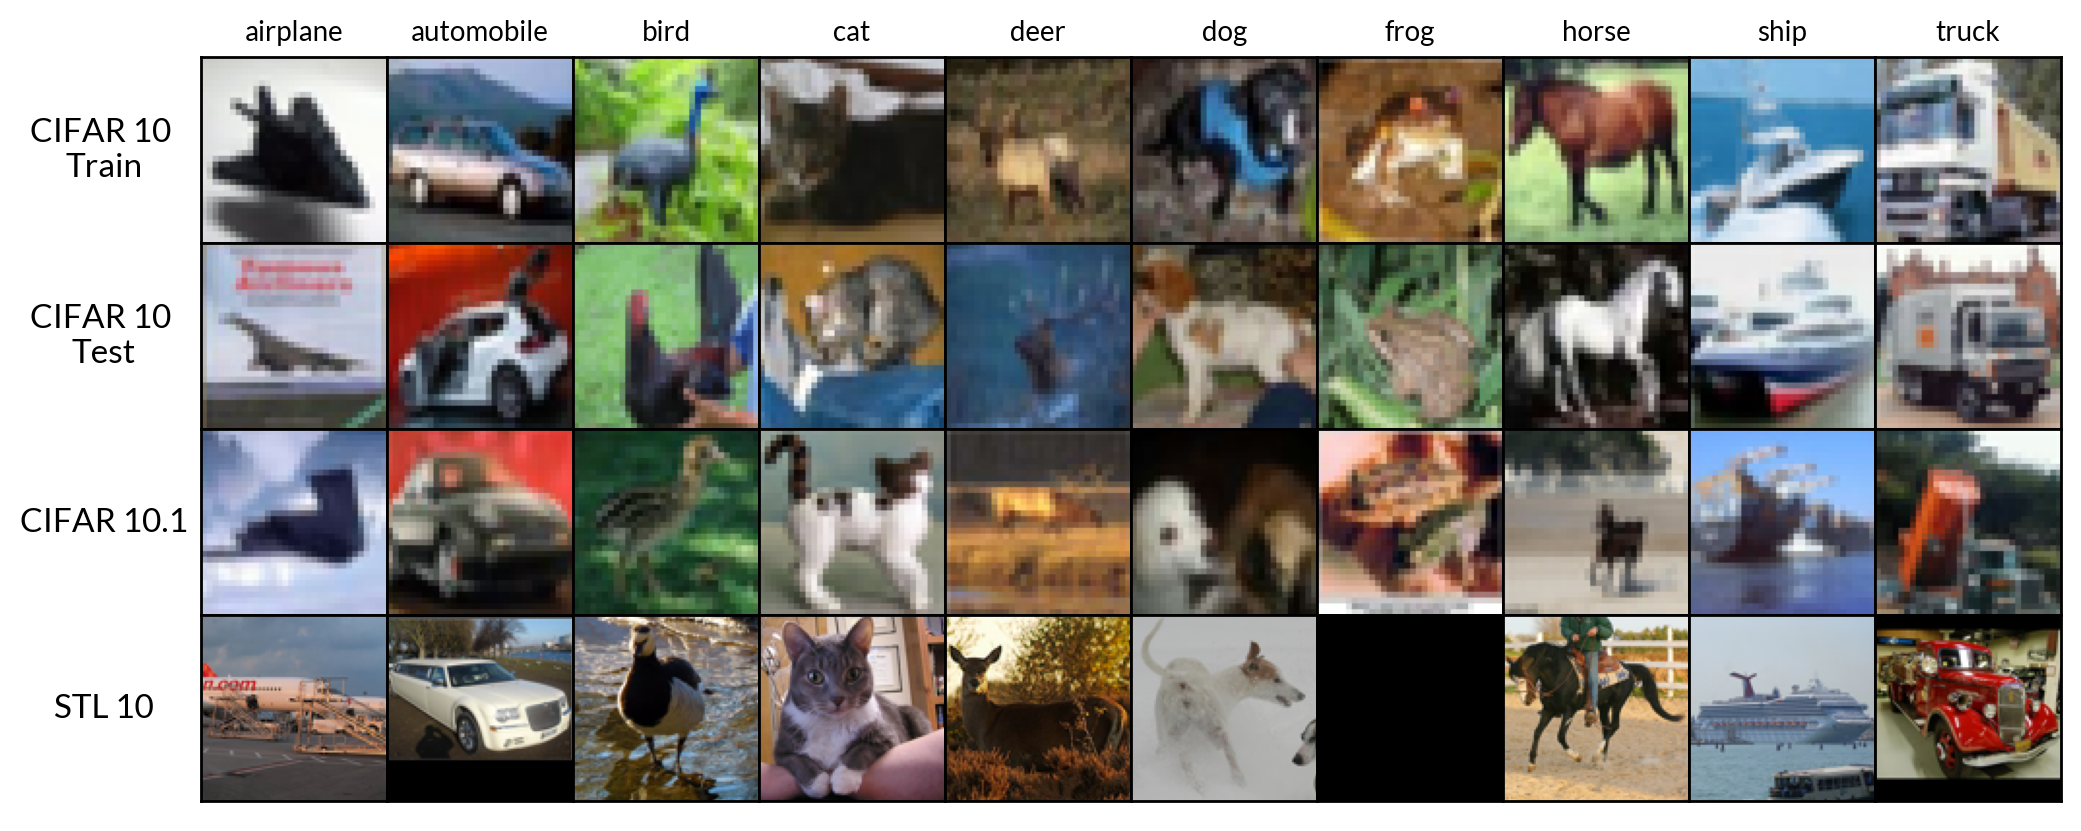

In [17]:
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["font.family"] = "Lato"
fontsize=20

fig = plt.figure(figsize=(12, 8), dpi=200)

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 10),
                 axes_pad=(0, 0.0))

for j, (key, indices) in enumerate(orig_img_dict.items()):
    dataset = datasets_dict[key]
    grid[j * 10].set_ylabel(title_dict[key], rotation='horizontal', 
                            ha='center', va='center', labelpad=35,
                            fontsize=12)

    for i, img_index in enumerate(indices):
        if "stl" in key and i > 5:
            i += 1
        grid[i + j*10].set_xticks([])
        grid[i + j*10].set_xticks([], minor=True)
        grid[i + j*10].set_yticks([])
        grid[i + j*10].set_yticks([], minor=True)
        [x.set_linewidth(1) for x in grid[i + j*10].spines.values()]

        img = dataset[img_index][0]
        img = T.ToPILImage()(img)
        grid[i + j*10].imshow(T.Resize(96, InterpolationMode.NEAREST)(img))
        if j == 0:
            grid[i].set_title(cifar10_train.classes[i], fontsize=10)

i = 6 + (j * 10)
grid[i].set_xticks([])
grid[i].set_xticks([], minor=True)
grid[i].set_yticks([])
grid[i].set_yticks([], minor=True)
[x.set_linewidth(1) for x in grid[i].spines.values()]

img = torch.zeros((3, 96, 96))
grid[i].imshow(img.permute(1, 2, 0))

plt.show()

## 1.2 Resize Interpolation Methods

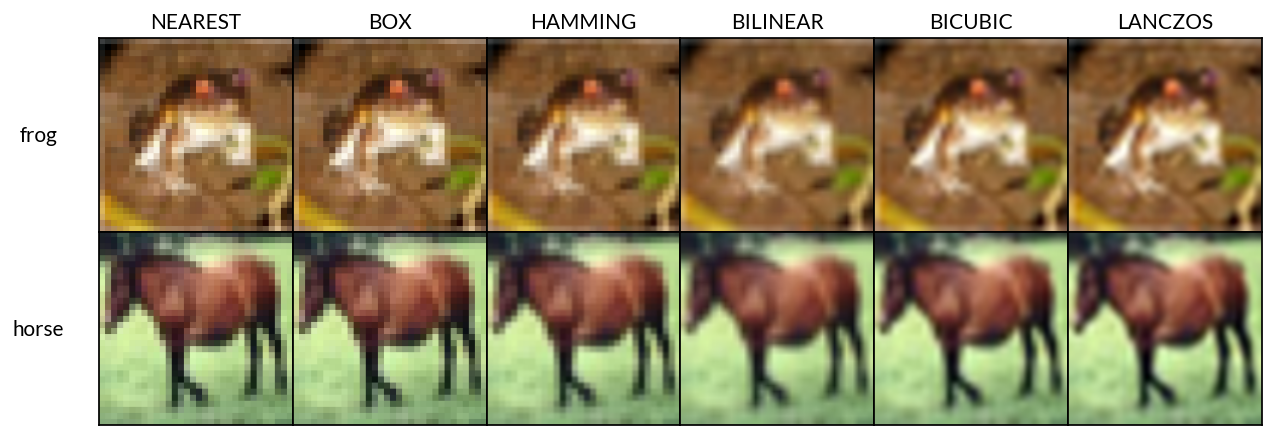

In [16]:
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["font.family"] = "Lato"
fontsize=20

dataset = datasets_dict["cifar10_train"]
indices = orig_img_dict["cifar10_train"][6:8]

interpolation_modes = [
    InterpolationMode.NEAREST, InterpolationMode.BOX,
    InterpolationMode.HAMMING, InterpolationMode.BILINEAR, 
    InterpolationMode.BICUBIC, InterpolationMode.LANCZOS]

nrows = len(interpolation_modes)
ncols = len(indices)

fig = plt.figure(figsize=(12, 5), dpi=125)

grid = ImageGrid(fig, 111,
                 nrows_ncols=(ncols, nrows),
                 axes_pad=(0, 0.0))


for i, img_index in enumerate(indices):
    grid[i * nrows].set_ylabel(cifar10_train.classes[i + 6], rotation='horizontal', 
                                     ha='center', va='center', labelpad=35, fontsize=12)
    
    for j, interpolation_mode in enumerate(interpolation_modes):
        grid[j + (i * nrows)].set_xticks([])
        grid[j + (i * nrows)].set_xticks([], minor=True)
        grid[j + (i * nrows)].set_yticks([])
        grid[j + (i * nrows)].set_yticks([], minor=True)
        [x.set_linewidth(1) for x in grid[j + (i * nrows)].spines.values()]

        img = dataset[img_index][0]
        img = T.ToPILImage()(img)
        grid[j + (i * nrows)].imshow(T.Resize(224, interpolation_mode)(img))
        if i == 0:
            grid[j].set_title(interpolation_mode.name, fontsize=12)


plt.show()

## 1.3 Corrupted Datasets (CIFAR 10C, CIFAR 10C bar)

These two datasets are used to benchmark a model's robustness to corruptions and perturbations.

* CIFAR 10C: [[paper](https://arxiv.org/pdf/1903.12261.pdf), [repo](https://github.com/hendrycks/robustness)]
* CIFAR 10C̄: [[paper](https://arxiv.org/pdf/2102.11273.pdf), [repo](https://github.com/facebookresearch/augmentation-corruption)]


In [7]:
CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]
CORRUPTIONS_BAR = [
    "blue_noise_sample", "lines", "brownish_noise", "pinch_and_twirl", 
    "transverse_chromatic_abberation", "checkerboard_cutout", "ripple", 
    "circular_motion_blur", "sparkles", "inverse_sparkles"]

CORRUPTIONS_TO_ENGLISH = {
    'gaussian_noise': "Gaussian Noise", 
    'shot_noise': "Shot Noise", 
    'impulse_noise': "Impulse Noise",
    'defocus_blur': "Defocus Blur",
    'glass_blur': "Glass Blur", 
    'motion_blur': "Motion Blur", 
    'zoom_blur': "Zoom Blur", 
    'snow': "Snow", 
    'frost': "Frost", 
    'fog': "Fog",
    'brightness': "Brightness", 
    'contrast': "Contrast", 
    'elastic_transform': "Elastic", 
    'pixelate': "Pixelate",
    'jpeg_compression': "JPEG",
    "blue_noise_sample": "Blue Noise Sample", 
    "lines": "Lines", 
    "brownish_noise": "Brown Noise", 
    "pinch_and_twirl": "Pinch and Twirl",
    "checkerboard_cutout": "Checkerboard", 
    "ripple": "Ripple", 
    "circular_motion_blur": "Circular Motion Blur", 
    "sparkles": "Sparkles",
    "inverse_sparkles": "Inverse Sparkles", 
    "transverse_chromatic_abberation": "Transverse Chromatic \n    Abberation"
}

img_dict = {}
for corruption in CORRUPTIONS:
    img_dict[corruption] = np.load(f"/content/drive/MyDrive/finetuning_project/data/CIFAR-10-C/{corruption}.npy")[300]

for corruption in CORRUPTIONS_BAR:
    img_dict[corruption] = np.load(f"/content/drive/MyDrive/finetuning_project/data/CIFAR-10-C-Bar/{corruption}.npy")[300]

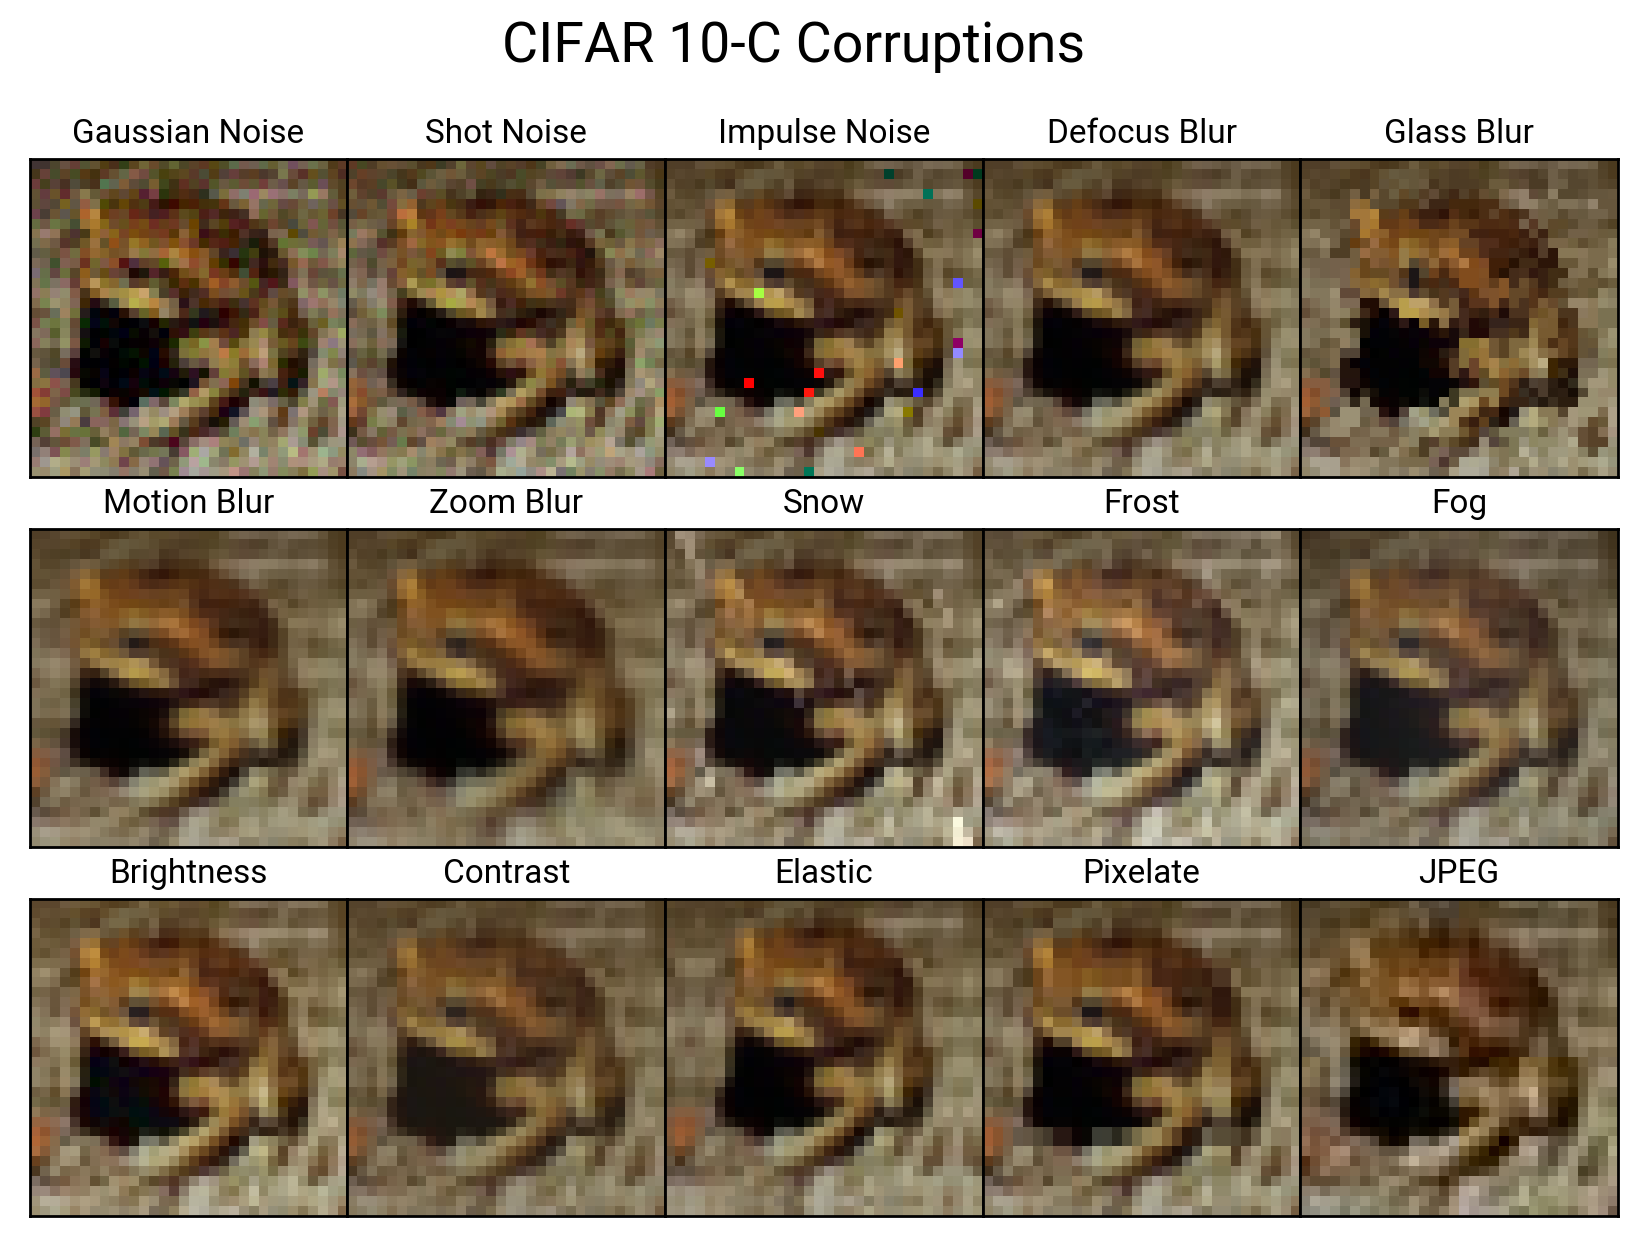

In [8]:
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["font.family"] = "Roboto"
fontsize=20

fig = plt.figure(figsize=(12, 7), dpi=200)
fig.suptitle('CIFAR 10-C Corruptions', fontsize=fontsize, y=.98)

grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 5),
                 axes_pad=(0, 0.26))

for i, (key, value) in enumerate(img_dict.items()):
    if i == 15:
        break
    img = Image.fromarray(np.uint8(value))
    grid[i].imshow(img)
    grid[i].set_title(CORRUPTIONS_TO_ENGLISH[key], y=1)
    grid[i].set_xticks([])
    grid[i].set_xticks([], minor=True)
    grid[i].set_yticks([])
    grid[i].set_yticks([], minor=True)
    [x.set_linewidth(1) for x in grid[i].spines.values()]

plt.show()

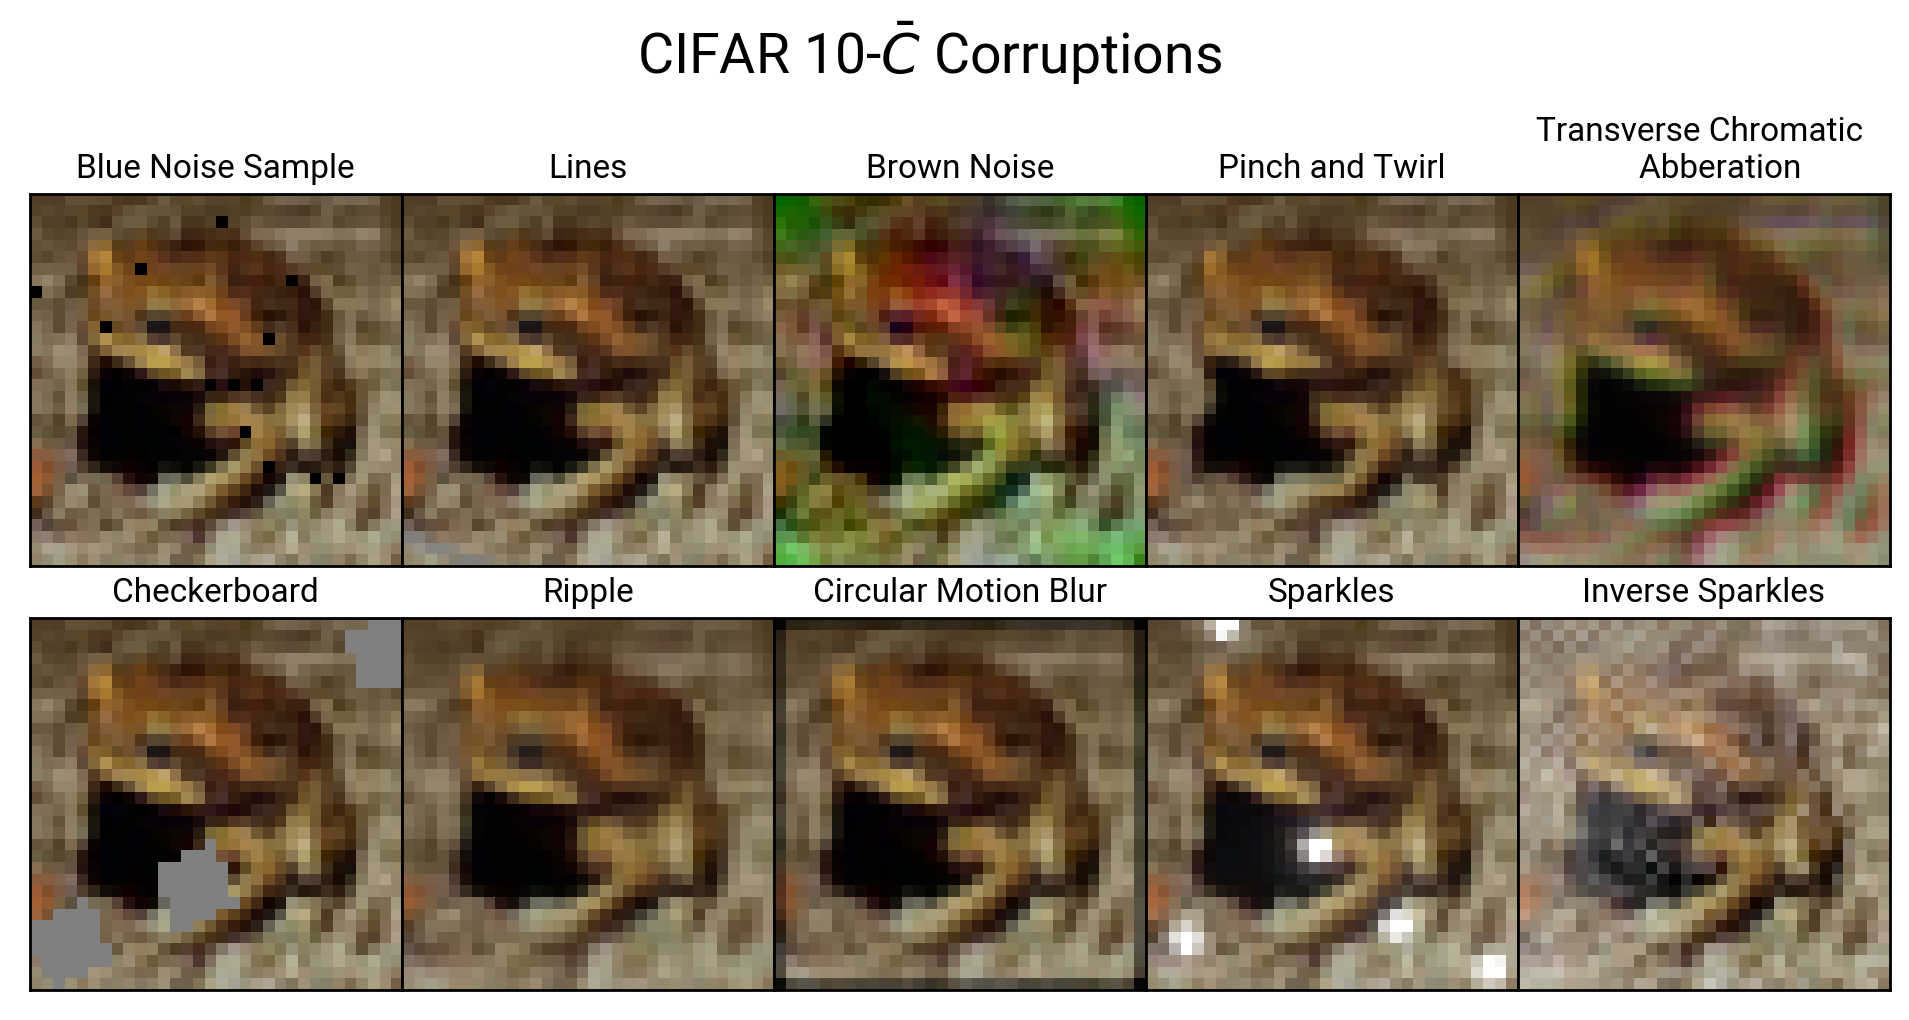

In [9]:
fig = plt.figure(figsize=(12, 6), dpi=200)
fig.suptitle(r'CIFAR 10-$\bar{C}$ Corruptions', fontsize=fontsize)

grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=(0, 0.26))

for i, (key, value) in enumerate(img_dict.items()):
    if i < 15:
        continue
    else:
        i -= 15
    img = Image.fromarray(np.uint8(value))
    grid[i].imshow(img)
    grid[i].set_title(CORRUPTIONS_TO_ENGLISH[key], y=1)
    grid[i].set_xticks([])
    grid[i].set_xticks([], minor=True)
    grid[i].set_yticks([])
    grid[i].set_yticks([], minor=True)
    [x.set_linewidth(1) for x in grid[i].spines.values()]

plt.show()

# 2. Visualizing pretrained features (Uses GPU)

## 2.1 Feature Extractor

In [10]:
data_dir = 'drive/MyDrive/finetuning_project/data/'
use_cuda = torch.cuda.is_available()

# Data Prepping
default_transformations = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])
lanczos_transformations = transforms.Compose([
        transforms.Resize(224, InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])
nearest_transformations = transforms.Compose([
        transforms.Resize(224, InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])

datasets = {
    "cifar10": CIFAR10(root=data_dir, train=True, transform=default_transformations, download=True),
    "cifar10.1": CIFAR10p1(root=f"{data_dir}cifar10p1", split="test", version="v6", transform=default_transformations),
    "stl10": STL10_CIFAR(torchvision.datasets.STL10(root=data_dir, split="test", download=True, transform=default_transformations)),
    "cifar10_lanczos": CIFAR10(root=data_dir, train=True, transform=lanczos_transformations, download=True),
    "cifar10_nearest": CIFAR10(root=data_dir, train=True, transform=nearest_transformations, download=True)
}

Files already downloaded and verified
Loading labels from file /content/drive/MyDrive/finetuning_project/data/cifar10p1/cifar10.1_v6_labels.npy
Loading image data from file /content/drive/MyDrive/finetuning_project/data/cifar10p1/cifar10.1_v6_data.npy
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = load_moco("drive/MyDrive/finetuning_project/models/moco_v2_800ep_pretrain.pth.tar")
model.fc = torch.nn.Identity()
if use_cuda:
    model = model.cuda()

model.eval()
features_dict = {}
labels_dict = {}

for dataset_name, dataset in datasets.items():
    features_dict[dataset_name] = []
    labels_dict[dataset_name] = []

    data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=256,
                                          num_workers=8,
                                          shuffle=False,
                                          pin_memory=True)
    with torch.no_grad():
        for data, labels in tqdm(data_loader):
            if use_cuda:
                data, labels = data.cuda(), labels.cuda() 
            features = model(data)
            features_dict[dataset_name].append(features.detach().cpu().numpy())
            labels_dict[dataset_name].append(labels.detach().cpu().numpy())

    features_dict[dataset_name] = np.squeeze(np.concatenate(features_dict[dataset_name]))
    labels_dict[dataset_name] = np.concatenate(labels_dict[dataset_name])

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

In [13]:
features_all = []
labels_all = []
dataset_id = []
for i, (dataset_name, features) in enumerate(features_dict.items()):
    features_all += [features_dict[dataset_name]]
    labels_all += [labels_dict[dataset_name]]
    dataset_id += [i] * len(labels_dict[dataset_name])

features_all = np.vstack(features_all)
labels_all = np.hstack(labels_all)
dataset_id = np.array(dataset_id)

mapper = umap.UMAP().fit(features_all)

features_umap = mapper.transform(features_all)

features_umap_df = pd.DataFrame(features_umap, columns = ['UMAP_1','UMAP_2'])
features_umap_df["dataset"] = dataset_id
features_umap_df["labels"] = labels_all

features_umap_df['dataset_name'] = features_umap_df.dataset.map(
    {
        0:'CIFAR 10',
        1:'CIFAR 10.1',
        2:'STL 10',
        3:'CIFAR 10 lanczos',
        4:'CIFAR 10 nearest',
    }
)
features_umap_df['labels_name'] = features_umap_df.labels.map(
    {
        0:'Airplane',
        1:'Automobike',
        2:'Bird',
        3:'Cat',
        4:'Deer',
        5:'Dog',
        6:'Frog',
        7:'Horse',
        8:'Ship',
        9:'Truck',
    }
)

with open(f'{data_dir}mocov2_features.pkl', 'wb') as f:
    pickle.dump([features_dict, labels_dict, features_umap_df], f)

## 2.2 Plotting Features

In [4]:
# Restart runtime here to not have to use GPU

import seaborn as sns


data_dir = 'drive/MyDrive/finetuning_project/data/'
use_cuda = torch.cuda.is_available()

with open(f'{data_dir}mocov2_features.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

[features_dict, labels_dict, features_umap_df] = loaded_dict

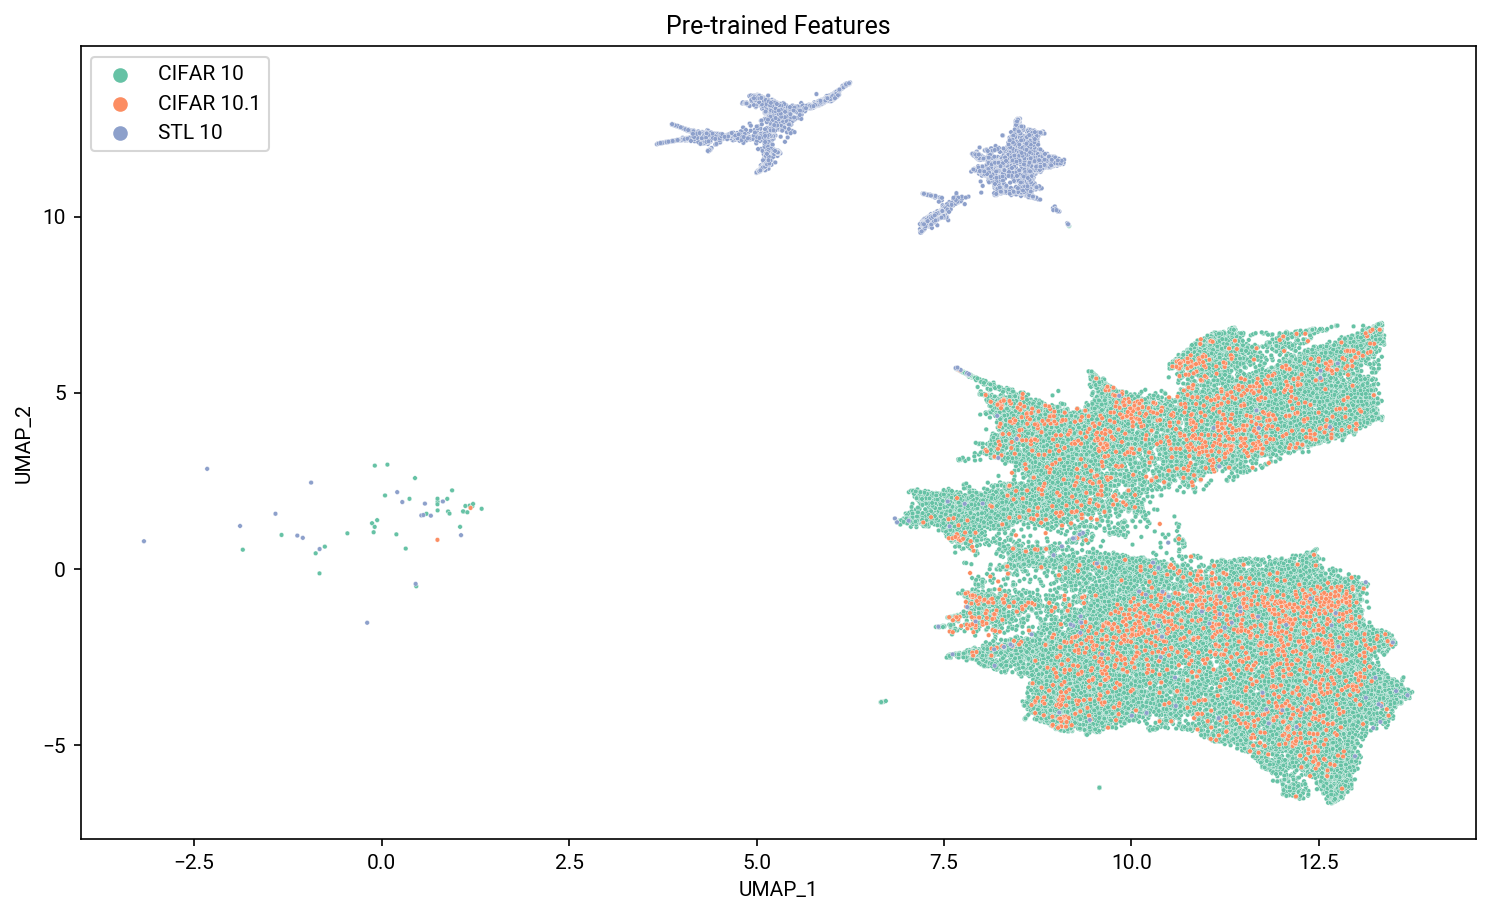

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.scatterplot(data=features_umap_df.iloc[:-100_000], x="UMAP_1", y="UMAP_2", hue="dataset_name", 
                palette="Set2", s=5, ax=ax)
ax.legend(loc='upper left')
ax.set_title("Pre-trained Features")
plt.show()

While the feature extractor seems to place CIFAR10.1 in the same space as CIFAR10, it places STL10 almost entirely elsewhere

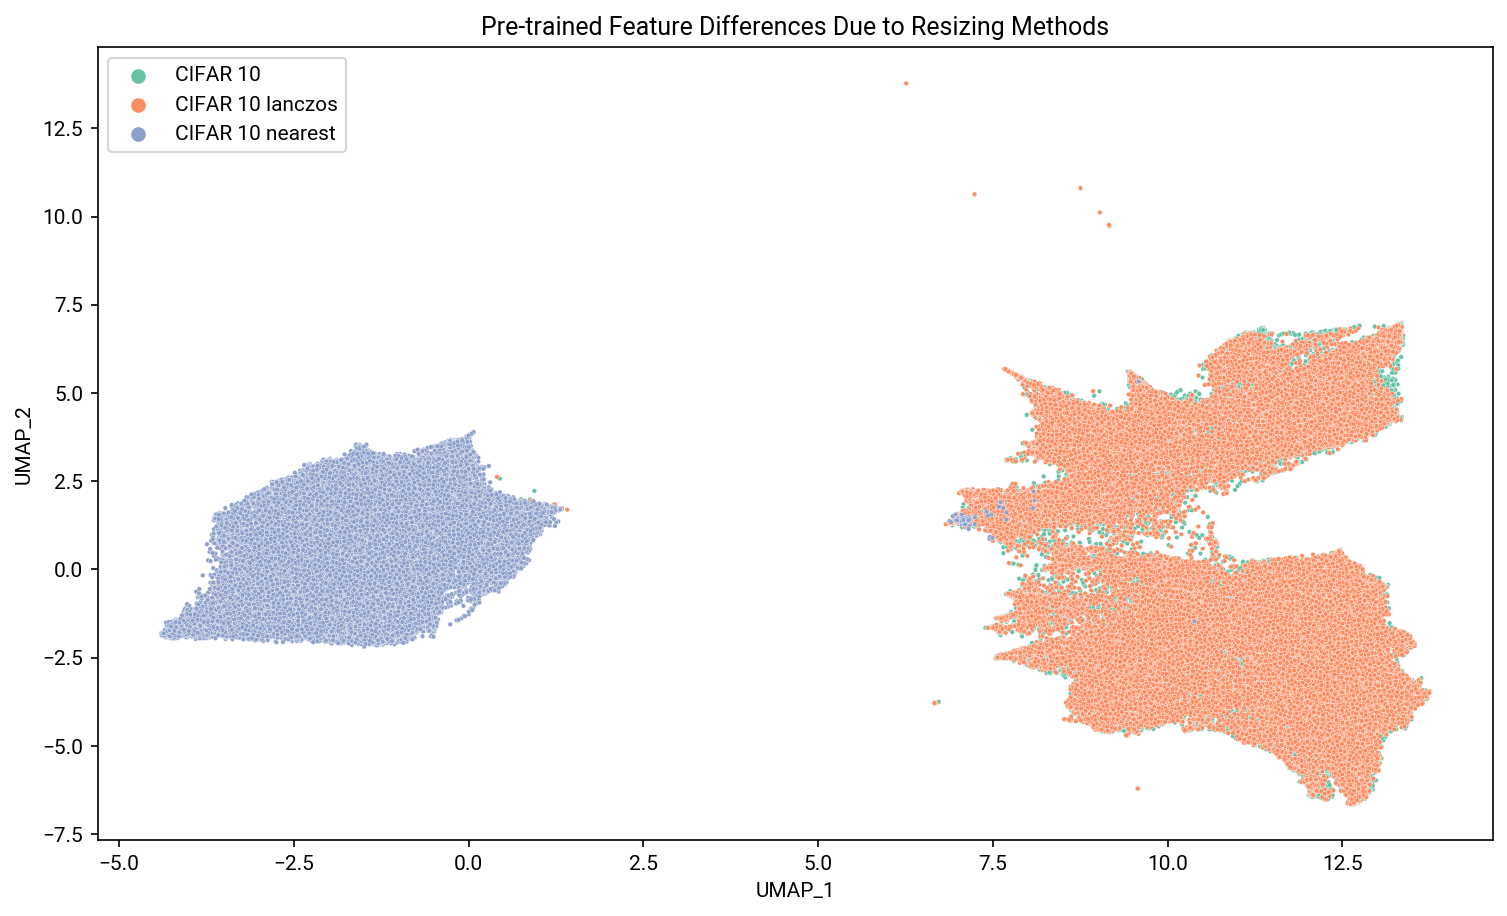

In [6]:
cifar_indices = features_umap_df['dataset_name'].isin(['CIFAR 10', 'CIFAR 10 lanczos', 'CIFAR 10 nearest'])

fig, ax = plt.subplots(figsize=(12, 7),)
ax = sns.scatterplot(data=features_umap_df[cifar_indices], x="UMAP_1", y="UMAP_2", hue="dataset_name", 
                palette="Set2", s=5, ax=ax)
ax.legend(loc='upper left')
ax.set_title("Pre-trained Feature Differences Due to Resizing Methods")
plt.show()

Interpolation method seems to have a great effect on the features extracted. The "Lanczos" interpolation method produces similar images to the default (bilinear) method. The "nearest" method produces a much more pixelated version that resembles the original sized image better.

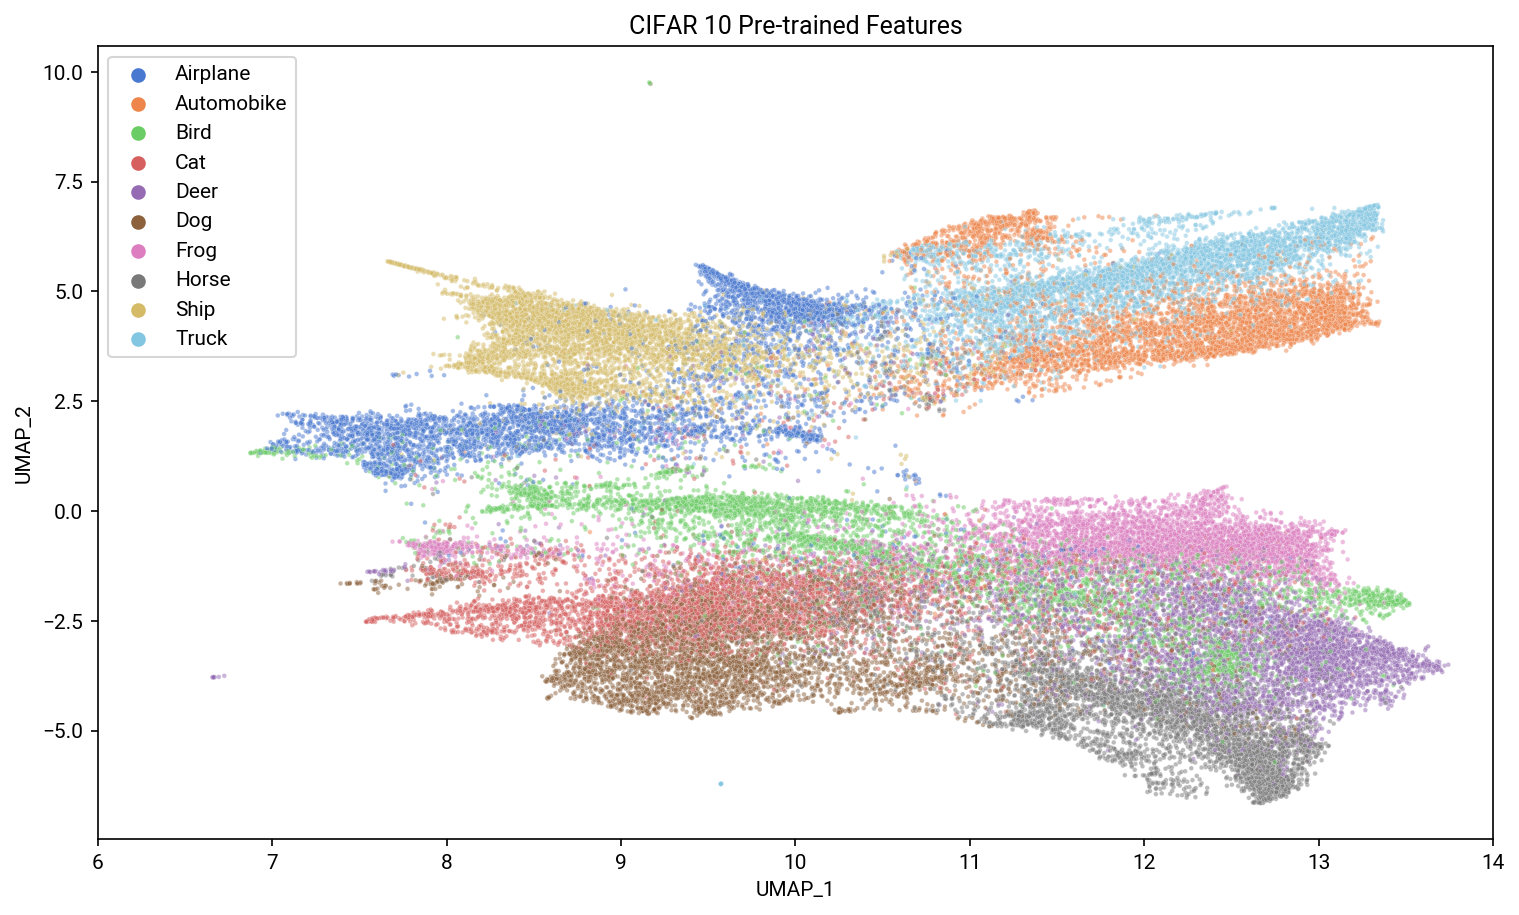

In [7]:
label_order = ['Airplane', 'Automobike', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
cifar_indices = features_umap_df['dataset_name'].isin(['CIFAR 10'])

fig, ax = plt.subplots(figsize=(12, 7),)
ax = sns.scatterplot(data=features_umap_df[cifar_indices], x="UMAP_1", y="UMAP_2", hue="labels_name", 
                hue_order=label_order, palette="muted", s=5, alpha=.5, ax=ax)
ax.legend(loc='upper left')
ax.set_title("CIFAR 10 Pre-trained Features")
ax.set_xlim([6, 14])
plt.show()

While there does seem to be seperation between the classes, there seems to be more than one cluster for each class ("Airplane"/blue has two).

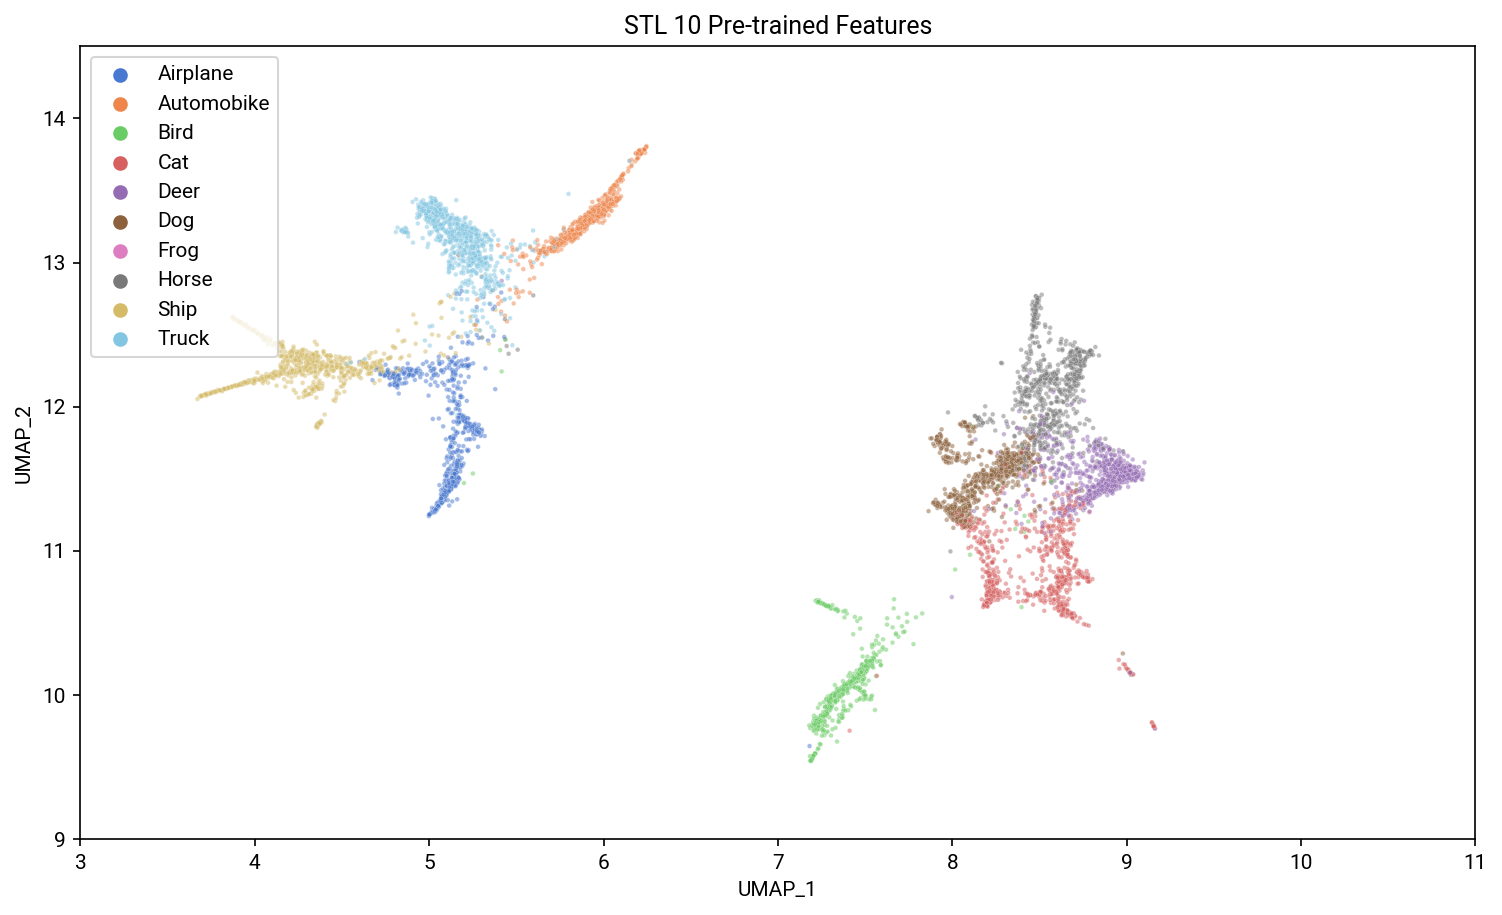

In [8]:
cifar_indices = features_umap_df['dataset_name'].isin(['STL 10'])

fig, ax = plt.subplots(figsize=(12, 7),)
ax = sns.scatterplot(data=features_umap_df[cifar_indices], x="UMAP_1", y="UMAP_2", hue="labels_name", 
                hue_order=label_order, palette="muted", s=5, alpha=.5, ax=ax)
ax.legend(loc='upper left')
ax.set_title("STL 10 Pre-trained Features")
ax.set_ylim([9, 14.5])
ax.set_xlim([3, 11])
plt.show()

The STL10 classes are much better seperated than the CIFAR10 ones

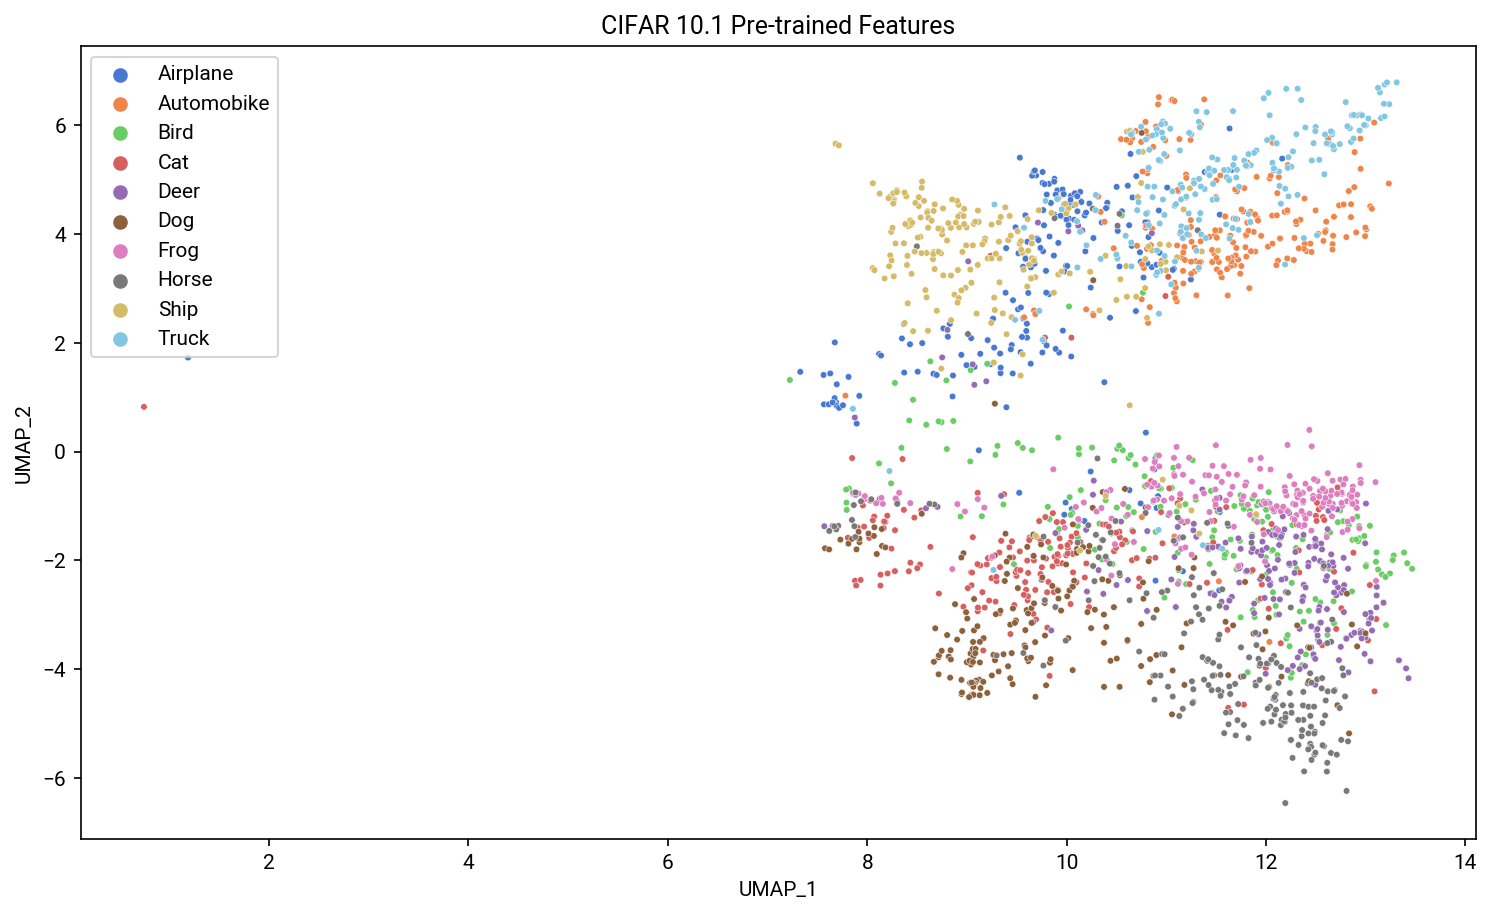

In [9]:
cifar_indices = features_umap_df['dataset_name'].isin(['CIFAR 10.1'])

fig, ax = plt.subplots(figsize=(12, 7),)
ax = sns.scatterplot(data=features_umap_df[cifar_indices], x="UMAP_1", y="UMAP_2", hue="labels_name", 
                hue_order=label_order, palette="muted", s=10, ax=ax)
ax.legend(loc='upper left')
ax.set_title("CIFAR 10.1 Pre-trained Features")
# ax.set_ylim([9, 14.5])
# ax.set_xlim([2.5, 10])
plt.show()

## 2.3 Comparing Features of Differently Resized Images using CKA


In [10]:
data_dir = 'drive/MyDrive/finetuning_project/data/'
use_cuda = torch.cuda.is_available()

# Data Prepping
default_transformations = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])
lanczos_transformations = transforms.Compose([
        transforms.Resize(224, InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])
nearest_transformations = transforms.Compose([
        transforms.Resize(224, InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
    ])

datasets = {
    "cifar10": CIFAR10(root=data_dir, train=True, transform=default_transformations, download=True),
    "cifar10_lanczos": CIFAR10(root=data_dir, train=True, transform=lanczos_transformations, download=True),
    "cifar10_nearest": CIFAR10(root=data_dir, train=True, transform=nearest_transformations, download=True)
}

model = load_moco("drive/MyDrive/finetuning_project/models/moco_v2_800ep_pretrain.pth.tar")
model.fc = torch.nn.Identity()

model_2 = load_moco("drive/MyDrive/finetuning_project/models/moco_v2_800ep_pretrain.pth.tar")
model_2.fc = torch.nn.Identity()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
cka_all = {}
for i, (dataset_name_1, dataset_1) in enumerate(datasets.items()):
    for j, (dataset_name_2, dataset_2) in enumerate(datasets.items()):
        if j <= i:
            continue
        data_loader_1 = torch.utils.data.DataLoader(dataset_1,
                                                  batch_size=64,
                                                  num_workers=4,
                                                  shuffle=False)
        data_loader_2 = torch.utils.data.DataLoader(dataset_2,
                                                  batch_size=64,
                                                  num_workers=4,
                                                  shuffle=False)

        layers = ["layer1", "layer2", "layer3", "layer4", "fc"]
        cka = CKA(model, model_2,
                  model1_name=dataset_name_1,
                  model2_name=dataset_name_2,
                  model1_layers=layers, 
                  model2_layers=layers,
                  device='cuda')

        cka.compare(data_loader_1, data_loader_2) # secondary dataloader is optional

        results = cka.export()  # returns a dict that contains model names, layer names
                                # and the CKA matrix
        cka_all[f"{dataset_name_1}x{dataset_name_2}"] = results['CKA']

with open(f'{data_dir}cka_all.pkl', 'wb') as f:
    pickle.dump(cka_all, f)

0 0
Skipping
0 1


| Comparing features |: 100%|██████████| 782/782 [01:39<00:00,  7.90it/s]


0 2


| Comparing features |: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s]


1 0
Skipping
1 1
Skipping
1 2


| Comparing features |: 100%|██████████| 782/782 [01:30<00:00,  8.63it/s]


2 0
Skipping
2 1
Skipping
2 2
Skipping


In [13]:
with open(f'{data_dir}cka_all.pkl', 'rb') as f:
    cka_all = pickle.load(f)

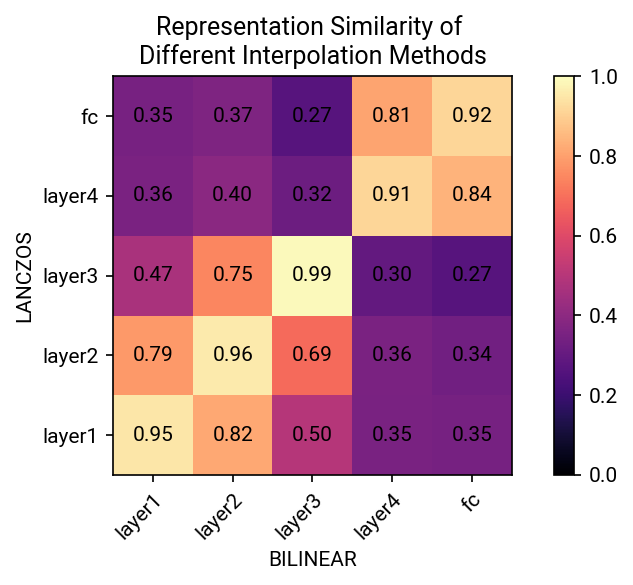

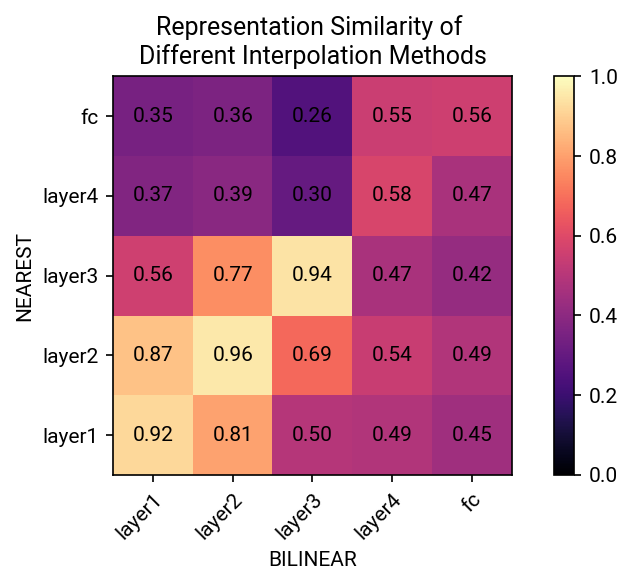

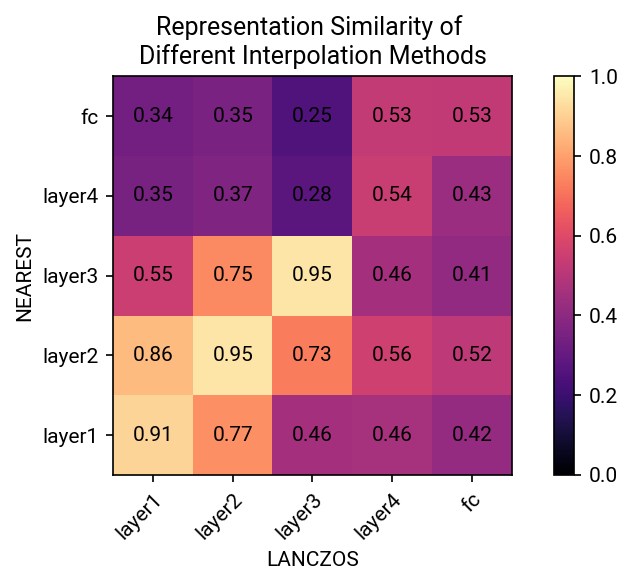

In [27]:
matplotlib.rcParams["font.family"] = "Roboto"

key_to_method = {"cifar10":"BILINEAR", 
                 "cifar10_lanczos": "LANCZOS", 
                 "cifar10_nearest": "NEAREST"}

for interpolation_methods, cka_matrix in cka_all.items():
    method_1, method_2 = interpolation_methods.split("x")
    method_1 = key_to_method[method_1]
    method_2 = key_to_method[method_2]

    fig, ax = plt.subplots()

    cmap = matplotlib.cm.magma
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    im = ax.imshow(cka_all[interpolation_methods], origin='lower', cmap=cmap, norm=norm)

    ax.set_xticks(np.arange(len(layers)))
    ax.set_yticks(np.arange(len(layers)))

    ax.set_xticklabels(labels=layers)
    ax.set_yticklabels(labels=layers)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(layers)):
        for j in range(len(layers)):
            text = ax.text(j, i, f"{cka_all[interpolation_methods][i, j].item():.2f}",
                          ha="center", va="center", color="k")

    ax.set_xlabel(method_1)
    ax.set_ylabel(method_2)
    ax.set_title("Representation Similarity of \nDifferent Interpolation Methods")
    plt.colorbar(im)
    fig.tight_layout()
    plt.show()